## Data Modeling

In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

plt.style.use("fivethirtyeight")

pd.options.display.max_columns = None #make all columns visible when printing the dataframe

In [2]:
delivery_data = pd.read_csv("naqsh route dataset.csv")
delivery_data.head()

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min)
0,0x4607,INDORES13DEL02,37,4.9,22.745049,75.892471,22.765049,75.912471,19-03-2022,11:30:00,11:45:00,conditions Sunny,High,2,Snack,motorcycle,0,No,Urban,(min) 24
1,0xb379,BANGRES18DEL02,34,4.5,12.913041,77.683237,13.043041,77.813237,25-03-2022,19:45:00,19:50:00,conditions Stormy,Jam,2,Snack,scooter,1,No,Metropolitian,(min) 33
2,0x5d6d,BANGRES19DEL01,23,4.4,12.914264,77.678400,12.924264,77.688400,19-03-2022,08:30:00,08:45:00,conditions Sandstorms,Low,0,Drinks,motorcycle,1,No,Urban,(min) 26
3,0x7a6a,COIMBRES13DEL02,38,4.7,11.003669,76.976494,11.053669,77.026494,05-04-2022,18:00:00,18:10:00,conditions Sunny,Medium,0,Buffet,motorcycle,1,No,Metropolitian,(min) 21
4,0x70a2,CHENRES12DEL01,32,4.6,12.972793,80.249982,13.012793,80.289982,26-03-2022,13:30:00,13:45:00,conditions Cloudy,High,1,Snack,scooter,1,No,Metropolitian,(min) 30


# Model Training
- Train regression based machine learning models and make predictions
- Make predictions and compare results
- Apply:
  - Standardization
  - Baseline estimation
  - Grid search cross-validaton for hyperparameter tuning
  - Hold-out method for test set
  - Examine feature importances

In [23]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, StackingRegressor, VotingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor

In [24]:
label_enc = LabelEncoder()

for category in categorical_features:
    variables_df[category] = label_enc.fit_transform(variables_df[category])

X = variables_df[numerical_features + categorical_features]
y = variables_df[target]

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True)

scaler = MinMaxScaler()

X_train = pd.DataFrame(
    data = scaler.fit_transform(X_train),
    columns = X_train.columns
    )

X_test = pd.DataFrame(
    data = scaler.fit_transform(X_test),
    columns = X_test.columns
    )

In [26]:
import statsmodels.api as sm
import pandas as pd

#  Train the linear regression model
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

# Option 1: Using sm.add_constant
X_train_with_intercept = sm.add_constant(X_train)

# Option 2: Concatenating directly
# X_train_with_intercept = pd.concat([pd.Series(1, index=X_train.index, name='const'), X_train], axis=1)

model_ols = sm.OLS(y_train, X_train_with_intercept).fit()

# Step 11: Print OLS summary
print(model_ols.summary())


                            OLS Regression Results                            
Dep. Variable:             Time_taken   R-squared:                       0.483
Model:                            OLS   Adj. R-squared:                  0.483
Method:                 Least Squares   F-statistic:                     1380.
Date:                Sun, 04 Feb 2024   Prob (F-statistic):               0.00
Time:                        14:17:24   Log-Likelihood:            -1.0312e+05
No. Observations:               31026   AIC:                         2.063e+05
Df Residuals:                   31004   BIC:                         2.065e+05
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

In [28]:
# Set the significance level
significance_level = 0.05

# Extract p-values from the model summary
p_values = model_ols.summary2().tables[1]['P>|t|']

# Identify variables with p-values greater than the significance level
variables_to_drop = p_values[p_values > significance_level].index

# Drop the variables from X_train
X_train_dropped = X_train.drop(variables_to_drop, axis=1)

# Re-run the linear regression model with the updated set of variables
X_train_dropped_with_intercept = sm.add_constant(X_train_dropped)
model_ols_dropped = sm.OLS(y_train, X_train_dropped_with_intercept).fit()

# Print the updated model summary
print(model_ols_dropped.summary())


                            OLS Regression Results                            
Dep. Variable:             Time_taken   R-squared:                       0.483
Model:                            OLS   Adj. R-squared:                  0.483
Method:                 Least Squares   F-statistic:                     1931.
Date:                Sun, 04 Feb 2024   Prob (F-statistic):               0.00
Time:                        14:20:42   Log-Likelihood:            -1.0312e+05
No. Observations:               31026   AIC:                         2.063e+05
Df Residuals:                   31010   BIC:                         2.064e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

In [30]:
X_test_dropped = X_test.drop(variables_to_drop, axis=1)

# Add a constant to the test set
X_test_dropped_with_intercept = sm.add_constant(X_test_dropped)

# Predict the target variable
y_pred = model_ols_dropped.predict(X_test_dropped_with_intercept)

# If needed, you can compare the predicted values with the actual values (y_test)
# For example, if y_test is the actual target variable for the test set
# You can calculate metrics like mean squared error (MSE) or R-squared for evaluation
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r_squared}')


Mean Squared Error: 44.52164024679942
R-squared: 0.4860221006568708


In [31]:
rmse = np.sqrt(mse)
rmse

6.672453839990159

### Baseline Result

In [22]:
#Baseline result with Ridge Regression

ridge = Ridge(alpha=1.0)
#Creates a Ridge Regression model with a regularization parameter (alpha) set to 1.0.
cv = KFold(n_splits=5) #Defines a 5-fold cross-validation strategy using KFold.
baseline_scores = cross_validate(ridge, X_train, y_train, cv=cv, scoring=('r2', 'neg_mean_squared_error'))

print("RMSE score of Ridge Regression:", np.mean(np.sqrt(-baseline_scores["test_neg_mean_squared_error"])))
print("R^2 score of Ridge Regression:", np.mean(baseline_scores["test_r2"]))

RMSE score of Ridge Regression: 6.56867778762569
R^2 score of Ridge Regression: 0.5049530070575131


In [23]:
#XGBoost
## Define the hyperparameter grid
params = {
        'max_depth': [3, 6, 10],
        'colsample_bytree': [0.5, 0.75],
        'subsample': [0.5, 0.75],
        'min_split_loss': [0, 0.5, 0.75],
        'reg_alpha': [0, 0.5, 0.75],
        'reg_lambda': [0, 0.5, 0.75]
        }
## Create an XGBoost Regressor with initial settings
xgb = XGBRegressor(
        learning_rate=0.5,
        n_estimators=200,
        objective='reg:squarederror',
        eval_metric='rmse',
        tree_method="auto",
        n_jobs=-1
        )
# Perform Grid Search with cross-validation
grid = GridSearchCV(estimator=xgb,
                   param_grid=params,
                   scoring='neg_root_mean_squared_error',
                   cv=3
                   )

grid.fit(X_train, y_train)
print("Best parameters:", grid.best_params_)
print("Lowest RMSE: ", grid.best_score_)

cv_results = grid.cv_results_
cv_results = pd.concat([pd.DataFrame(cv_results["params"]),
                        pd.DataFrame(cv_results["mean_test_score"], columns=["test_mean_rmse"])],
                       axis=1)

cv_results.sort_values(by="test_mean_rmse", ascending=False)[:5]

Best parameters: {'colsample_bytree': 0.75, 'max_depth': 3, 'min_split_loss': 0.5, 'reg_alpha': 0.5, 'reg_lambda': 0.75, 'subsample': 0.75}
Lowest RMSE:  -4.163133999110385


,colsample_bytree,max_depth,min_split_loss,reg_alpha,reg_lambda,subsample,test_mean_rmse
209,0.75,3,0.75,0.50,0.75,0.75,-4.163134
191,0.75,3,0.50,0.50,0.75,0.75,-4.163134
173,0.75,3,0.00,0.50,0.75,0.75,-4.163307
205,0.75,3,0.75,0.50,0.00,0.75,-4.165382
213,0.75,3,0.75,0.75,0.50,0.75,-4.181539


In [24]:
#Select a low learning rate to avoid overfitting

xgb = XGBRegressor(
    max_depth=3,
    colsample_bytree=0.75,
    subsample=0.75,
    min_split_loss=0.5,
    reg_lambda=0.5,
    reg_alpha=0.5,
    learning_rate=0.01,
    n_estimators=5000,
    objective='reg:squarederror',
    eval_metric='rmse',
    tree_method="auto",
    verbosity=1,
    early_stopping_rounds=30,
    n_jobs=-1
)

cv = KFold(n_splits=5)
for i, (train_index, val_index) in enumerate(cv.split(X_train)):

    xgb.fit(
        X_train.iloc[train_index], y_train.iloc[train_index],
        eval_set = [(X_train.iloc[val_index], y_train.iloc[val_index])],
        verbose=1000
        )

    y_pred = xgb.predict(X_train.iloc[val_index])
    rmse = np.sqrt(mean_squared_error(y_train.iloc[val_index], y_pred))
    r2 = r2_score(y_train.iloc[val_index], y_pred)

    print(f"\nRMSE of Fold {i+1}:", f'{rmse: .2f}')
    print(f"R^2 Score of Fold {i+1}:", f'{r2: .2f}\n')

[0]	validation_0-rmse:9.25113
[1000]	validation_0-rmse:4.28379
[2000]	validation_0-rmse:4.15516
[3000]	validation_0-rmse:4.11818
[4000]	validation_0-rmse:4.09915
[4999]	validation_0-rmse:4.08770

RMSE of Fold 1:  4.09
R^2 Score of Fold 1:  0.81

[0]	validation_0-rmse:9.23858
[1000]	validation_0-rmse:4.29524
[2000]	validation_0-rmse:4.18513
[3000]	validation_0-rmse:4.15343
[3713]	validation_0-rmse:4.13868

RMSE of Fold 2:  4.14
R^2 Score of Fold 2:  0.80

[0]	validation_0-rmse:9.33895
[1000]	validation_0-rmse:4.28510
[2000]	validation_0-rmse:4.14834
[3000]	validation_0-rmse:4.10942
[3936]	validation_0-rmse:4.09146

RMSE of Fold 3:  4.09
R^2 Score of Fold 3:  0.81

[0]	validation_0-rmse:9.24441
[1000]	validation_0-rmse:4.26133
[2000]	validation_0-rmse:4.16352
[3000]	validation_0-rmse:4.13465
[4000]	validation_0-rmse:4.11712
[4040]	validation_0-rmse:4.11689

RMSE of Fold 4:  4.12
R^2 Score of Fold 4:  0.80

[0]	validation_0-rmse:9.44007
[1000]	validation_0-rmse:4.38617
[2000]	validation_0

In [17]:
#Random Forest
params = {
        'max_depth': [3, 6, 10, 50],
        'n_estimators': [100, 250, 500, 1000],
        'min_samples_split' : [2, 5, 8],
        'min_samples_leaf' : [1, 3, 5]
        }

rnd = RandomForestRegressor(max_features=None)
grid = GridSearchCV(estimator=rnd,
                   param_grid=params,
                   scoring='neg_root_mean_squared_error',
                   cv=3
                   )

grid.fit(X_train, y_train)
print("Best parameters:", grid.best_params_)
print("Lowest RMSE: ", grid.best_score_)

Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 250}
Lowest RMSE:  -3.7319813085766143


In [18]:

cv_results = grid.cv_results_
cv_results = pd.concat([pd.DataFrame(cv_results["params"]),
                        pd.DataFrame(cv_results["mean_test_score"], columns=["test_mean_rmse"])],
                       axis=1)

cv_results.sort_values(by="test_mean_rmse", ascending=False)[:5]

,max_depth,min_samples_leaf,min_samples_split,n_estimators,test_mean_rmse
73,10,1,2,250,-3.731981
92,10,3,8,100,-3.731984
82,10,1,8,500,-3.732305
79,10,1,5,1000,-3.732805
83,10,1,8,1000,-3.732849


In [19]:
#Support Vector Regressor
params = {
        'kernel': ["linear", "poly", "rbf", "sigmoid"],
        'gamma': ["scale", "auto"],
        'C': [0, 0.5, 0.75, 1.0]
        }

svr = SVR()

grid = GridSearchCV(estimator=svr,
                   param_grid=params,
                   scoring='neg_root_mean_squared_error',
                   cv=3
                   )

grid.fit(X_train, y_train)
print("Best parameters:", grid.best_params_)
print("Lowest RMSE: ", grid.best_score_)

Best parameters: {'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}
Lowest RMSE:  -5.766015777414359


In [20]:

cv_results = grid.cv_results_
cv_results = pd.concat([pd.DataFrame(cv_results["params"]),
                        pd.DataFrame(cv_results["mean_test_score"], columns=["test_mean_rmse"])],
                       axis=1)

cv_results.sort_values(by="test_mean_rmse", ascending=False)[:5]

,C,gamma,kernel,test_mean_rmse
26,1.00,scale,rbf,-5.766016
25,1.00,scale,poly,-5.773666
17,0.75,scale,poly,-5.810905
18,0.75,scale,rbf,-5.834659
9,0.50,scale,poly,-5.870556


### Final Predictions

In [25]:
#Tuned Parameters for each algorithm
xgb = XGBRegressor(
    max_depth=3,
    colsample_bytree=0.75,
    subsample=0.75,
    min_split_loss=0.5,
    reg_lambda=0.5,
    learning_rate=0.01,
    n_estimators=3800,
    objective='reg:squarederror',
    eval_metric='rmse',
    tree_method="auto",
    n_jobs=-1
    )

rf = RandomForestRegressor(
    max_features=None,
    max_depth = 10,
    n_estimators = 250,
    min_samples_split = 2,
    min_samples_leaf = 1
    )

svr = SVR(
    kernel = 'rbf',
    gamma = 'scale',
    C = 1.0
    )

algorithms = {
            'Baseline (Ridge)': ridge,
            'XGBoost': xgb,
            'Random Forest': rf,
            'Support Vector Regressor': svr
            }

In [26]:
rmse_scores, r2_scores = {}, {}

for algorithm, model in algorithms.items():

    model.fit(X_train, y_train)
    #y_pred = model.predict(X_test).reshape(-1,1)
    y_pred = model.predict(X_test)

    rmse_scores[algorithm] = np.sqrt(mean_squared_error(y_test, y_pred))
    r2_scores[algorithm] = r2_score(y_test, y_pred)

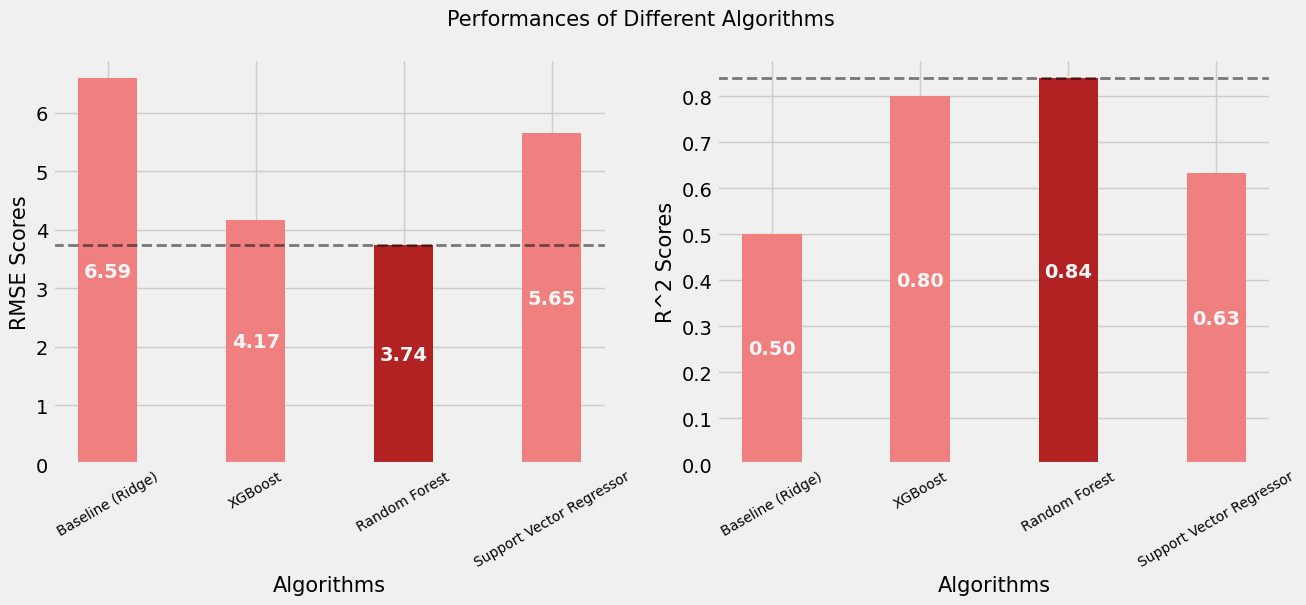

In [27]:
#plot results on test set
fig, ax = plt.subplots(1,2,figsize=(14,5))

ind = np.arange(len(r2_scores)) + 0.3
width = 0.4

for i,score_dict in enumerate([rmse_scores, r2_scores]):
    scores = list(score_dict.values())

    bars = ax[i].bar(ind, scores, width, color="lightcoral")
    ax[i].bar_label(bars, fmt='%.2f', weight='bold', label_type='center', color='whitesmoke')
    ax[i].patches[scores.index(min(scores)) if i==0 else scores.index(max(scores))].set_facecolor('firebrick') # Highlight the best resulted bar
    ax[i].axhline(min(scores) if i==0 else max(scores), ls="--", alpha=0.5, color="black", lw=2) # Draw a dashed line of the best algorithm
    ax[i].set_xticks(ind, labels=score_dict.keys(), fontsize=10, rotation=30)
    ax[i].set_xlabel("Algorithms", fontsize=15)
    ax[i].set_ylabel("RMSE Scores" if i==0 else "R^2 Scores", fontsize=15)

fig.suptitle("Performances of Different Algorithms", fontsize=15)
plt.show()

These two graphs show the performance of four different algorithms on a regression task.

The algorithms are:
- Baseline (Ridge)
 - XGBoost
- Random Forest
 - Support Vector Regressor
 
The first graph shows the root mean squared error (RMSE) of each algorithm. RMSE is a common metric for measuring the difference between predicted and actual values. Lower RMSE scores indicate better performance. As you can see, Random Forest  has the lowest RMSE score, followed by XGBoost, Support Vector Regressor, and Baseline (Ridge).

The second graph shows the R-squared score of each algorithm. R-squared is a metric that measures how well the variation in the predicted values matches the variation in the actual values. Higher R-squared scores indicate better performance. Again,Random Forest has the highest R-squared score, followed by XGBoost, Support Vector Regressor, and Baseline (Ridge).

Overall, these graphs suggest that Random Forest is the best performing algorithm for this regression task, followed by  XGBoost, Support Vector Regressor, and Baseline (Ridge).

In [47]:
model = algorithms["Random Forest"]
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
residuals = [t-p for p,t in zip(y_pred, y_test)]

'''Residuals are the differences between the actual values (y_test) and the predicted values (y_pred). 

This residuals line calculates the residuals for each data point by subtracting the predicted value from the true value.

Residuals are useful for understanding how well your model is performing.
Ideally, you want residuals to be close to zero, indicating that your model's predictions are accurate. 
Large residuals may suggest areas where your model is not performing well.
'''

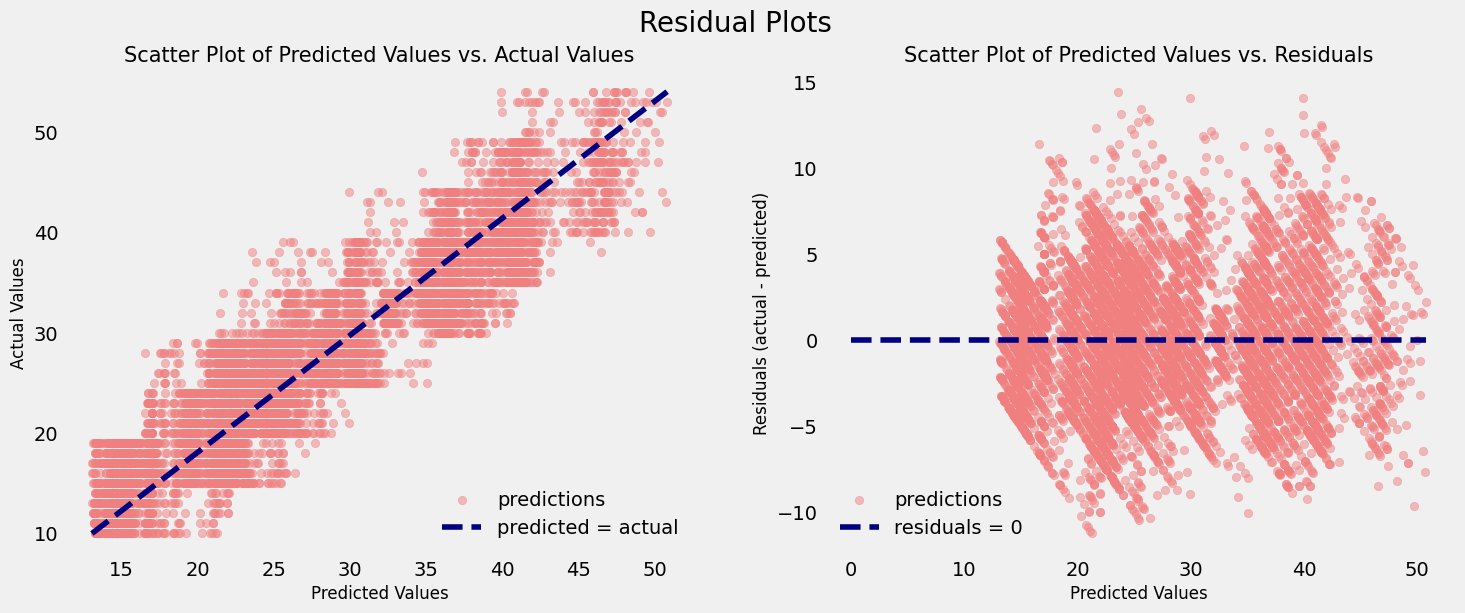

In [48]:
#Residual plots

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, ax = plt.subplots(1,2,figsize=(16,6))

ax[0].scatter(x=y_pred, y=y_test, alpha=0.5, color="lightcoral", label="predictions")
ax[0].plot([min(y_pred), max(y_pred)], [min(y_test), max(y_test)], ls="dashed", color="navy", label="predicted = actual")
ax[0].legend(loc="lower right", frameon=False)

ax[0].set_xlabel("Predicted Values", fontsize=12)
ax[0].set_ylabel("Actual Values", fontsize=12)
ax[0].set_title("Scatter Plot of Predicted Values vs. Actual Values", fontsize=15)
ax[0].grid(visible=False)


ax[1].scatter(x=y_pred, y=residuals, alpha=0.5, color="lightcoral", label="predictions")
ax[1].plot([0, max(y_pred)], [0,0], ls="dashed", color="navy", label="residuals = 0")
ax[1].legend(loc="lower left", frameon=False)

ax[1].set_xlabel("Predicted Values", fontsize=12)
ax[1].set_ylabel("Residuals (actual - predicted)", fontsize=12)
ax[1].set_title("Scatter Plot of Predicted Values vs. Residuals", fontsize=15)
ax[1].grid(visible=False)

fig.suptitle("Residual Plots", fontsize=20)
plt.show()

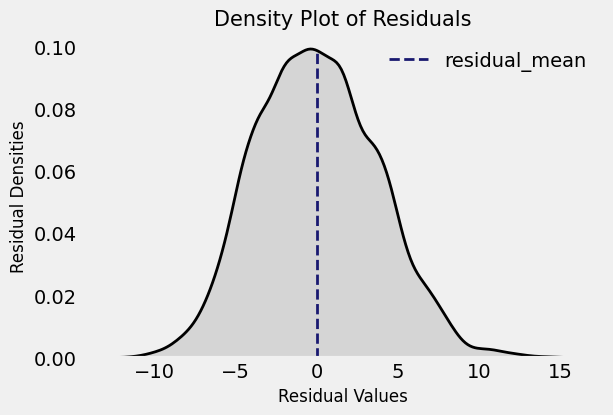

In [49]:
fig, ax = plt.subplots(figsize=(6,4))

ax = sns.kdeplot(residuals, shade=False, color="black", linewidth=2)

kdeline = ax.lines[0]
xs = kdeline.get_xdata()
ys = kdeline.get_ydata()

height = np.interp(np.mean(residuals), xs, ys)
ax.vlines(np.mean(residuals), 0, height, color='midnightblue', ls='dashed', lw=2, label="residual_mean")

ax.fill_between(xs, 0, ys, facecolor='dimgrey', alpha=0.2)

ax.legend(loc="best", frameon=False)

ax.set_xlabel("Residual Values", fontsize=12)
ax.set_ylabel("Residual Densities", fontsize=12)
ax.set_title("Density Plot of Residuals", fontsize=15)
ax.grid(visible=False)
plt.show()

In [51]:
!pip install mycolorpy

  Preparing metadata (setup.py) ... done
  Created wheel for mycolorpy: filename=mycolorpy-1.5.1-py3-none-any.whl size=3851 sha256=4b035020cb3e5bb93a298006905c2222d11878ba6f37e2d80da1d3d4d71369c0
  Stored in directory: /root/.cache/pip/wheels/d6/1d/04/f8bfb8b04e3daba330b3f377c041b89304271ff98fb6704946
Successfully built mycolorpy


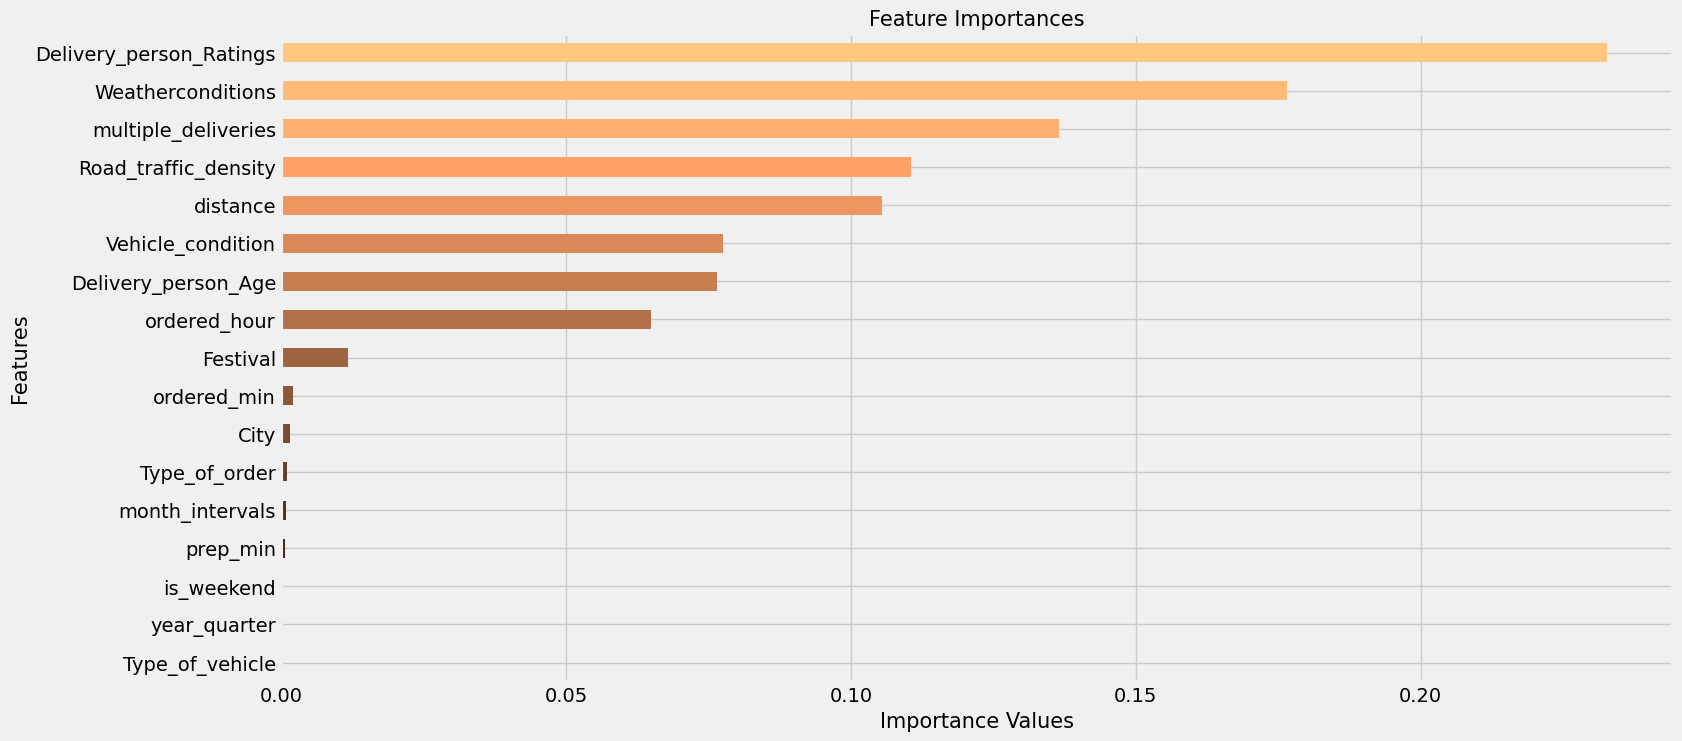

In [52]:
from mycolorpy import colorlist as mcp

imp = list(model.feature_importances_)

importances = pd.DataFrame({"feature": X_train.columns, "importance": imp})
importances = importances.sort_values(by="importance")

colors = mcp.gen_color(cmap='copper', n=len(importances))

ax = importances.plot(kind='barh', x='feature', y='importance', figsize=(16,8), color=colors, legend=False)
#ax.axvline(0.05, ls="--", color="firebrick")
plt.xlabel("Importance Values", fontsize=15)
plt.ylabel("Features", fontsize=15)
plt.title("Feature Importances", fontsize=15)
plt.show()

In [53]:
#Sort feature importances by descending order

importances = importances.sort_values(by="importance", ascending=False)
importances.reset_index(inplace=True, drop=True)
importances.head()

,feature,importance
0,Delivery_person_Ratings,0.232608
1,Weatherconditions,0.176599
2,multiple_deliveries,0.136601
3,Road_traffic_density,0.110598
4,distance,0.105413


In [54]:
r2_scores_new = []
for feature_num in range(len(importances)):

    new_features = importances["feature"][:feature_num+1]

    X_train_new = X_train[new_features]
    X_test_new = X_test[new_features]

    model.fit(X_train_new, y_train)
    pred = model.predict(X_test_new).reshape(-1,1)

    r2_scores_new.append(r2_score(pred, y_test))

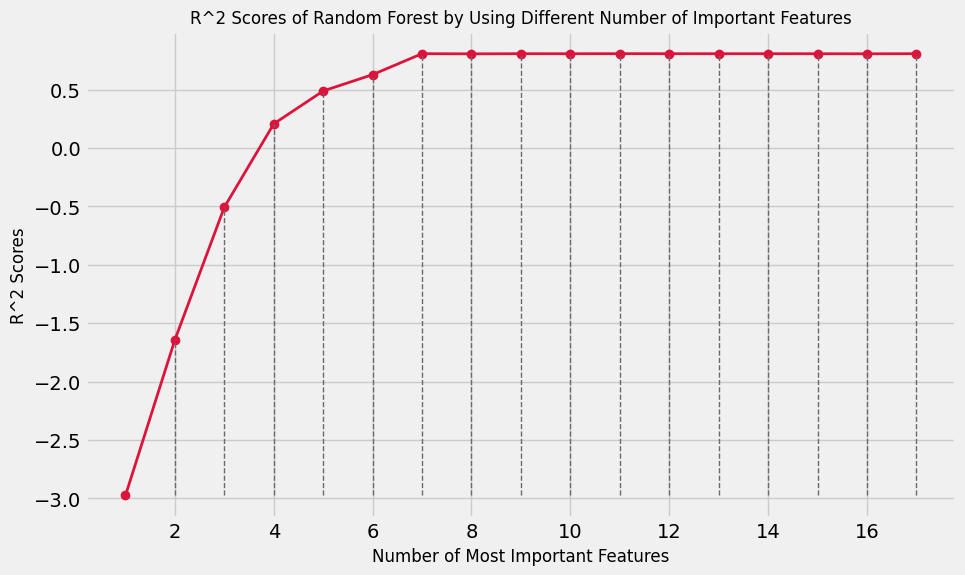

In [55]:
plt.figure(figsize=(10,6))

plt.plot(range(1,len(importances)+1), r2_scores_new, marker="o", lw=2, color="crimson")

plt.vlines(range(1,len(importances)+1), min(r2_scores_new), r2_scores_new, color='dimgray', ls='dashed', lw=1)

plt.xlabel("Number of Most Important Features", fontsize=12)
plt.ylabel("R^2 Scores", fontsize=12)
plt.title("R^2 Scores of Random Forest by Using Different Number of Important Features", fontsize=12)

plt.show()

In [56]:
#Most important features
importances[:7]

,feature,importance
0,Delivery_person_Ratings,0.232608
1,Weatherconditions,0.176599
2,multiple_deliveries,0.136601
3,Road_traffic_density,0.110598
4,distance,0.105413
5,Vehicle_condition,0.077576
6,Delivery_person_Age,0.076504


Certainly! Based on the comparison between the Random Forest feature importances and the results from the Ordinary Least Squares (OLS) summary, it appears that the Random Forest model has identified important features that align with the statistical significance observed in the OLS analysis.

The features identified as crucial by Random Forest, such as "Delivery_person_Ratings," "Weatherconditions," "multiple_deliveries," "Road_traffic_density," "Distance," "Vehicle_condition," and "Delivery_person_Age," demonstrate high importance according to the model. Interestingly, these features align with the ones identified in the OLS summary with low p-values, indicating statistical significance.

This alignment between the machine learning model's feature importance and the statistical significance observed in the OLS analysis strengthens our confidence in the importance of these features. It suggests that not only are these features influential in predicting the 'Time_taken' (target variable) according to the Random Forest model, but their significance is also supported by traditional statistical methods.

In addition to the alignment between Random Forest feature importance and OLS significance, it's noteworthy that the Random Forest model outperforms other regression models, including Linear Regression, Ridge Regression, XGBoost, and Support Vector Regression (SVR).

The evaluation metrics, specifically the Root Mean Squared Error (RMSE) and R-squared (R²), indicate that the Random Forest model consistently exhibits superior performance. It achieves the lowest RMSE, reflecting better predictive accuracy, and the highest R², indicating a greater proportion of variance explained in the target variable.